In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import gc
import psutil
from ase.io import read
import ase
import os
from heapq import nsmallest
import openbabel as ob
%matplotlib inline
print(os.listdir("../../inputs"))
print('ase version', ase.__version__)

def show_ram_usage():
    py = psutil.Process(os.getpid())
    print('RAM usage: {} GB'.format(py.memory_info()[0]/2. ** 30))
show_ram_usage()

['test.csv', 'train.csv', 'potential_energy.csv', 'magnetic_shielding_tensors.csv', 'scalar_coupling_contributions.csv', 'sample_submission.csv', 'mulliken_charges.csv', 'structures.csv', 'dipole_moments.csv', 'structures']
ase version 3.17.0
RAM usage: 0.12685775756835938 GB


In [2]:
%%time
train_dtypes = {
    'molecule_name': 'category',
    'atom_index_0': 'int8',
    'atom_index_1': 'int8',
    'type': 'category',
    'scalar_coupling_constant': 'float32'
}
# Load the data
train = pd.read_csv('../../inputs/train.csv', index_col='id', dtype=train_dtypes)
# ---------------------------------------------------------------
show_ram_usage()

# Let's work with a single dataframe JHN to begin with

def build_type_dataframe(base, coupling_type):
    base = base[base['type'] == coupling_type].drop('type', axis=1).copy()
    #base = base.drop(['atom_index_0', 'atom_index_1', 'molecule_name'], axis=1)
    return base

df_3JHN = build_type_dataframe(train, '3JHN')
print(df_3JHN.shape)
print(display(df_3JHN.head()))

del train
gc.collect()
# ---------------------------------------------------------------
# Extract mol_name, [atom_index0, atom_index1] as a list
def extract_base(base):
    mol_name = base['molecule_name'].to_numpy()
    atom_index0 = base['atom_index_0'].to_numpy()
    atom_index1 = base['atom_index_1'].to_numpy()
    return mol_name, atom_index0, atom_index1

mol_train, atom_index0_train, atom_index1_train = extract_base(df_3JHN)

#-----------------------------------------------------------------
print(f'There are {df_3JHN.shape[0]} rows in train data.')
print('')
print(f'There are {mol_train.shape[0]} rows in mol_train data.')
print('')
print(f"There are {df_3JHN['molecule_name'].nunique()} distinct molecules in train data.")
print(f"There are {df_3JHN['atom_index_0'].nunique()} unique atoms.")
print('')
print(f'There are {atom_index0_train.shape[0]} rows in atom_index0_train data.')
print(f'There are {atom_index1_train.shape[0]} rows in atom_index1_train data.')
print('')
# ---------------------------------------------------------------
show_ram_usage()

/home/sher/anaconda2/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


RAM usage: 0.28623199462890625 GB
(166415, 4)


,molecule_name,atom_index_0,atom_index_1,scalar_coupling_constant
id,,,,
73,dsgdb9nsd_000010,3,2,0.880802
78,dsgdb9nsd_000010,4,2,0.880957
82,dsgdb9nsd_000010,5,2,0.880871
213,dsgdb9nsd_000019,4,2,-0.052074
218,dsgdb9nsd_000019,5,2,1.611320


None
There are 166415 rows in train data.

There are 166415 rows in mol_train data.

There are 45774 distinct molecules in train data.
There are 25 unique atoms.

There are 166415 rows in atom_index0_train data.
There are 166415 rows in atom_index1_train data.

RAM usage: 0.21675491333007812 GB
CPU times: user 3.09 s, sys: 284 ms, total: 3.37 s
Wall time: 3.24 s


In [3]:
%%time
obConversion = ob.OBConversion()
obConversion.SetInFormat("xyz")

structdir='../../inputs/structures/'
mols_ob=[]
mols_files=os.listdir(structdir)
mols_index=dict(map(reversed,enumerate(mols_files)))
for f in mols_index.keys():
    mol = ob.OBMol()
    obConversion.ReadFile(mol, structdir+f) 
    mols_ob.append(mol)
# ---------------------------------------------------------------
def Atoms(molname,AtomId1,AtomId2):
    mol=mols_ob[mols_index[molname+'.xyz']]
    return mol, mol.GetAtomById(AtomId1), mol.GetAtomById(AtomId2)

def SecondAtom(bond,FirstAtom):
    if FirstAtom.GetId()==bond.GetBeginAtom().GetId(): return bond.GetEndAtom()
    else: return bond.GetBeginAtom()

def Angle2J(molname,AtomId1,AtomId2,debug=False):
    mol,firstAtom,lastAtom=Atoms(molname,AtomId1,AtomId2)
    if debug: print (mol.GetFormula())
    if debug: print(firstAtom.GetType(),firstAtom.GetId(),':',lastAtom.GetType(),lastAtom.GetId())
    for b in ob.OBAtomBondIter(firstAtom): # all bonds for first atom
        secondAtom=SecondAtom(b,firstAtom)
        lastBond=secondAtom.GetBond(lastAtom)
        if lastBond: # found!
            if debug: print('middle',secondAtom.GetId(),secondAtom.GetType())
            return firstAtom.GetAngle(secondAtom,lastAtom)

print(Angle2J('dsgdb9nsd_000003',1,2,debug=True)) #water
def Torsion3J(molname,AtomId1,AtomId2,debug=False):
    mol,firstAtom,lastAtom=Atoms(molname,AtomId1,AtomId2)
    if debug: print (molname, mol.GetFormula())
    if debug: print(firstAtom.GetType(),firstAtom.GetId(),':',lastAtom.GetType(),lastAtom.GetId())
    for b in ob.OBAtomBondIter(firstAtom): # all bonds for first atom
        secondAtom=SecondAtom(b,firstAtom)
        for b2 in ob.OBAtomBondIter(secondAtom): # all bonds for second atom 
            thirdAtom=SecondAtom(b2,secondAtom)
            lastBond=thirdAtom.GetBond(lastAtom)
            if lastBond: # found!
                if debug: print(secondAtom.GetType(),secondAtom.GetId(),'<->',thirdAtom.GetType(),thirdAtom.GetId())
                return mol.GetTorsion(firstAtom,secondAtom,thirdAtom,lastAtom)
print(Torsion3J('dsgdb9nsd_000007',2,5,debug=True))

torsion = []
for i, m in enumerate(mol_train):
    t = Torsion3J(m,int(atom_index0_train[i]),int(atom_index1_train[i]),debug=False) 
    torsion.append(t)
print(len(torsion))
show_ram_usage()

# Build complete feature set on original data frame
torsion1 = np.array(torsion)
print(df_3JHN.shape[0])
print(torsion1.shape[0])
print(len(torsion))
df_3JHN['dih'] = torsion1
print('Dihedral added!')
show_ram_usage()

A = [0.001, 0.01, 0.1, 1.0, 1.2] 

J1_list = []
J2_list = []
for k, m in enumerate(torsion):
    J1_list.append(np.cos(m))
    J1x_list = []
    for i, val1 in enumerate(A):
        J1x = val1 * (np.cos(m)) + np.cos(2*m)
        J1x_list.append(J1x)
    J2_list.append(J1x_list)

J1 = np.array(J1_list)
J2 = np.array(J2_list)
print('Done J1, J2')
print(len(J2))
print(len(J2[0]))
print('')
df_3JHN['J1'] = J1
for i in range(5):
    J2x_temp = J2[:, i]
    df_3JHN[f'J2_{i}'] = J2x_temp
print(len(df_3JHN))
print(display(df_3JHN.head()))
show_ram_usage()

H2O
HO 1 : HO 2
middle 0 O3
103.71576124592411
dsgdb9nsd_000007 C2H6
H 2 : H 5
C3 0 <-> C3 1
60.00280550635594
166415
RAM usage: 1.4259223937988281 GB
166415
166415
166415
Dihedral added!
RAM usage: 1.4284400939941406 GB
Done J1, J2
166415
5

166415


,molecule_name,atom_index_0,atom_index_1,scalar_coupling_constant,dih,J1,J2_0,J2_1,J2_2,J2_3,J2_4
id,,,,,,,,,,,
73,dsgdb9nsd_000010,3,2,0.880802,14.915754,-0.702274,-0.014323,-0.020644,-0.083849,-0.715896,-0.856350
78,dsgdb9nsd_000010,4,2,0.880957,134.911670,-0.984409,0.937138,0.928279,0.839682,-0.046286,-0.243168
82,dsgdb9nsd_000010,5,2,0.880871,-105.087639,-0.155086,-0.952052,-0.953447,-0.967405,-1.106983,-1.138000
213,dsgdb9nsd_000019,4,2,-0.052074,39.379522,-0.109394,-0.976175,-0.977160,-0.987005,-1.085460,-1.107339
218,dsgdb9nsd_000019,5,2,1.611320,160.948407,-0.747051,0.115423,0.108700,0.041465,-0.630881,-0.780291


None
RAM usage: 1.4896202087402344 GB
CPU times: user 47.5 s, sys: 3.4 s, total: 50.9 s
Wall time: 1min 10s


In [4]:
%%time

def convert_xyz_to_mol(mol_id):
    mol = read(f'../../inputs/structures/{mol_id}.xyz')
    return mol

# Distance r_b with atom indices
def get_rb(mol, atom_index0, atom_index1):
    r_b = mol.get_distance(atom_index0, atom_index1)
    return r_b

# Acquire r_b, r_i, theta_i for the molecule
def get_ri(mol, rb, atom_index0, atom_index1):
    r_i = []
    angles = []
    for i in range((len(mol))):
        if i == atom_index0:
            #theta_i.append(0)
            r_i.append(0)
            continue
        if i == atom_index1:
            #theta_i.append(0)
            r_i.append(0)
            continue
        angle1 = mol.get_angle(atom_index0, i, atom_index1)
        angle2 = mol.get_angle(atom_index0, atom_index1, i)
        angle3 = mol.get_angle(atom_index1, atom_index0, i)
        angles.append([angle1, angle2, angle3])
        # Get theta from center of bond
        theta = 180 - angle3 - (angle1/2.0)
        # Get distance from center of bond
        r = (rb/2.0)*(np.sin(np.radians(angle3)))/(np.sin(np.radians(angle1/2.0)))
        r_i.append(r) 
    return r_i

def get_theta_i(mol, r_i, atom_index0, atom_index1):
    #angles = []
    theta_i = []
    for i in range((len(mol))):
        if i == atom_index0:
            theta_i.append(0)
            continue
        if i == atom_index1:
            theta_i.append(0)
            continue
        angle1 = mol.get_angle(atom_index0, i, atom_index1)
        #angle2 = mol.get_angle(atom_index0, atom_index1, i)
        angle3 = mol.get_angle(atom_index1, atom_index0, i)
        #angles.append([angle1, angle2, angle3])
        # Get theta from center of bond
        theta = 180 - angle3 - (angle1/2.0)
        theta_i.append(theta) 
    return theta_i

def get_G0(r_b, eta, mu):
    G0_list = []
    for val2 in mu:
        for val1 in eta:
            G0 = np.exp(-val1*(r_b-val2)**2)
            G0_list.append(G0)
    return G0_list

# Define the cut-off function
def fcut(Ri):
    if Ri <= Rc:
        y = 0.5*(np.cos(np.pi*Ri/Rc)+1.0)
    else:
        y = 0
    return y

# Let's Define the radial function G1_atomic

def get_G1(mol, rb, index_0, index_1):
    natom = len(mol)
    atoms = mol.get_atomic_numbers()
    r_i = get_ri(mol, rb, index_0, index_1)
    G1_par = np.zeros(shape=(np1, 5)) # H C N O F 
    for i in range(natom):
        if i == index_0:
            continue
        if i == index_1:
            continue
        for j in range(np1):
            eta_m = p1[j][0]
            mu_m =  p1[j][1]
            G1_temp = np.exp(-eta_m*(r_i[i]-mu_m)**2)*fcut(r_i[i])
            if atoms[i] == 1:
                G1_par[j][0] = G1_par[j][0] + G1_temp
                continue
            if atoms[i] == 6:
                G1_par[j][1] = G1_par[j][1] + G1_temp
                continue
            if atoms[i] == 7:
                G1_par[j][2] = G1_par[j][2] + G1_temp
                continue
            if atoms[i] == 8:
                G1_par[j][3] = G1_par[j][3] + G1_temp
                continue
            if atoms[i] == 9:
                G1_par[j][4] = G1_par[j][4] + G1_temp
    return G1_par

def get_G1_G2(mol, rb, index_0, index_1):
    natom = len(mol)
    atoms = mol.get_atomic_numbers()
    r_i = get_ri(mol, rb, index_0, index_1)    
    theta_i = get_theta_i(mol, r_i, index_0, index_1)
    G1_par = np.zeros(shape=(np2, 5)) # H C N O F 
    G2_pos = np.zeros(shape=(np2, 5)) # H C N O F
    G2_neg = np.zeros(shape=(np2, 5)) # H C N O F
    G2_pos1 = np.zeros(shape=(np2, 5)) # H C N O F
    G2_neg1 = np.zeros(shape=(np2, 5)) # H C N O F
    for i in range(natom):
        if i == index_0:
            continue
        if i == index_1:
            continue
        for j in range(np2):
            eta_m = p2[j][0]
            mu_m =  p2[j][1]
            G1_temp = np.exp(-eta_m*(r_i[i]-mu_m)**2)*fcut(r_i[i])
            G2pos_temp = ((1 + abs(np.cos(np.radians(theta_i[i]))))**1.0)*G1_temp
            G2neg_temp = ((1 + abs(np.cos(np.radians(theta_i[i]))))**4.0)*G1_temp
            G2pos1_temp = ((1 + abs(np.cos(np.radians(theta_i[i]))))**8.0)*G1_temp
            G2neg1_temp = ((1 + abs(np.cos(np.radians(theta_i[i]))))**16.0)*G1_temp
            if atoms[i] == 1:
                G1_par[j][0] = G1_par[j][0] + G1_temp
                G2_pos[j][0] = G2_pos[j][0] + G2pos_temp
                G2_neg[j][0] = G2_neg[j][0] + G2neg_temp
                G2_pos1[j][0] = G2_pos1[j][0] + G2pos_temp
                G2_neg1[j][0] = G2_neg1[j][0] + G2neg_temp
                continue
            if atoms[i] == 6:
                G1_par[j][1] = G1_par[j][1] + G1_temp
                G2_pos[j][1] = G2_pos[j][1] + G2pos_temp
                G2_neg[j][1] = G2_neg[j][1] + G2neg_temp
                G2_pos1[j][1] = G2_pos1[j][1] + G2pos_temp
                G2_neg1[j][1] = G2_neg1[j][1] + G2neg_temp
                continue
            if atoms[i] == 7:
                G1_par[j][2] = G1_par[j][2] + G1_temp
                G2_pos[j][2] = G2_pos[j][2] + G2pos_temp
                G2_neg[j][2] = G2_neg[j][2] + G2neg_temp
                G2_pos1[j][2] = G2_pos1[j][2] + G2pos_temp
                G2_neg1[j][2] = G2_neg1[j][2] + G2neg_temp
                continue
            if atoms[i] == 8:
                G1_par[j][3] = G1_par[j][3] + G1_temp
                G2_pos[j][3] = G2_pos[j][3] + G2pos_temp
                G2_neg[j][3] = G2_neg[j][3] + G2neg_temp
                G2_pos1[j][3] = G2_pos1[j][3] + G2pos_temp
                G2_neg1[j][3] = G2_neg1[j][3] + G2neg_temp
                continue
            if atoms[i] == 9:
                G1_par[j][4] = G1_par[j][4] + G1_temp
                G2_pos[j][4] = G2_pos[j][4] + G2pos_temp
                G2_neg[j][4] = G2_neg[j][4] + G2neg_temp
                G2_pos1[j][4] = G2_pos1[j][4] + G2pos_temp
                G2_neg1[j][4] = G2_neg1[j][4] + G2neg_temp
    return G1_par, G2_pos, G2_neg, G2_pos1, G2_neg1,  r_i


### Define Globals
Rc = 6.0

# Define eta, mu
eta0 = [500]
mu0 = [2.2, 2.4, 2.6, 2.8, 3.0, 3.2]
np0 = len(eta0) * len(mu0)


#eta1 = [0.001, 0.01, 0.1, 0.5, 1.0, 4.0, 40.0] # Gives a score of -0.32 mu = 0.0,2.0
#mu1 = [0.0, 2.0]
eta1 = [6.3775510]
mu1 = np.arange(0.0, 5.6, 0.25)
np1 = len(eta1) * len(mu1)
p1 =  [[i,j] for i in eta1 for j in mu1]

eta2 = [0.1, 0.5]
mu2 = [0.0]
np2 = len(eta2) * len(mu2)
p2 =  [[i,j] for i in eta2 for j in mu2]

    

rb_train = []
ri_list = []
G0_train_list = []
G1_train_list = []
G1a_train_list = []
G2pos_train_list = []
G2neg_train_list = []
G2pos1_train_list = []
G2neg1_train_list = []
for i, m in enumerate(mol_train):
    mol = convert_xyz_to_mol(m)
    rb = get_rb(mol, atom_index0_train[i], atom_index1_train[i])
    rb_train.append(rb)
    G0 = get_G0(rb, eta0, mu0)
    G0_train_list.append(G0)
    G1 = get_G1(mol, rb, atom_index0_train[i], atom_index1_train[i])
    G1a, G2_pos, G2_neg, G2_pos1, G2_neg1, ri = get_G1_G2(mol, rb, atom_index0_train[i], atom_index1_train[i])
    G1_train_list.append(G1)
    G1a_train_list.append(G1a)
    G2pos_train_list.append(G2_pos)
    G2neg_train_list.append(G2_neg)
    G2pos1_train_list.append(G2_pos1)
    G2neg1_train_list.append(G2_neg1)
    ri_list.append(ri)
    
G0_train = np.array(G0_train_list)
G1_array = np.array(G1_train_list)
G1a_array = np.array(G1a_train_list)
G2pos_array = np.array(G2pos_train_list)
G2neg_array = np.array(G2neg_train_list)
G2pos1_array = np.array(G2pos1_train_list)
G2neg1_array = np.array(G2neg1_train_list)

G1_train = np.zeros(shape=(len(G1_array), np1*5))
G1a_train = np.zeros(shape=(len(G1a_array), np2*5))
G2pos_train = np.zeros(shape=(len(G2pos_array), np2*5))
G2neg_train = np.zeros(shape=(len(G2neg_array), np2*5))
G2pos1_train = np.zeros(shape=(len(G2pos1_array), np2*5))
G2neg1_train = np.zeros(shape=(len(G2neg1_array), np2*5))
for i, row1 in enumerate(G1_array):
    G1_train[i] = row1.flatten()
for i, row1 in enumerate(G1a_array):
    G1a_train[i] = row1.flatten()
for i, row1 in enumerate(G2pos_array):
    G2pos_train[i] = row1.flatten()
for i, row1 in enumerate(G2neg_array):
    G2neg_train[i] = row1.flatten()
for i, row1 in enumerate(G2pos1_array):
    G2pos1_train[i] = row1.flatten()
for i, row1 in enumerate(G2neg1_array):
    G2neg1_train[i] = row1.flatten()
ri_0 = []
ri_1 = []
for i, val in enumerate(ri_list):
    ri_0_temp = nsmallest(4, val)[2]
    ri_1_temp = nsmallest(4, val)[3]
    ri_0.append(ri_0_temp)
    ri_1.append(ri_1_temp)
# ---------------------------------------------------------------
print('Length of rb :')
print(len(rb_train))
print('Length of G0 :')
print(len(G0_train))
print(len(G0_train[0])) # Should be (eta0 x mu0)
print(len(G0_train[1]))
print('Length of G1 :')
print(len(G1_train))
print(len(G1_train[0])) # Should be  (eta1 x mu1)
print(len(G1_train[1]))
print('Length of G2pos :')
print(len(G2pos_train))
print(len(G2pos_train[0])) # Should be  (eta1 x mu1)
print(len(G2pos_train[1]))
print('Length of G2neg :')
print(len(G2neg_train))
print(len(G2neg_train[0])) # Should be  (eta1 x mu1)
print(len(G2neg_train[1]))
# ---------------------------------------------------------------
show_ram_usage()

Length of rb :
166415
Length of G0 :
166415
6
6
Length of G1 :
166415
115
115
Length of G2pos :
166415
10
10
Length of G2neg :
166415
10
10
RAM usage: 2.5299301147460938 GB
CPU times: user 23min 42s, sys: 3.82 s, total: 23min 46s
Wall time: 23min 46s


In [5]:
%%time
# Build complete feature set on original data frame
#df_3JHN['dih'] = torsion
print('Dihedral added!')
df_3JHN['rb'] = rb_train
print('rb added!')
print('')
df_3JHN['ri0'] = ri_0
df_3JHN['ri1'] = ri_1
print('Lowest two ri added!')
print('')
for i in range(np0):
    df_3JHN[f'g0_{i}'] = G0_train[:, i]
print('G0 added!')
print('')
for i in range(np1*5):
    df_3JHN[f'g1_{i}'] = G1_train[:, i]
for i in range(np2*5):
    df_3JHN[f'g2_1_{i}'] = G2pos_train[:, i]
    df_3JHN[f'g2_4_{i}'] = G2neg_train[:, i]
    df_3JHN[f'g2_8_{i}'] = G2pos1_train[:, i]
    df_3JHN[f'g2_16_{i}'] = G2neg1_train[:, i]
    #df_JHN = df_JHN.drop(['atom_index_0', 'atom_index_1', 'molecule_name', 'type'], axis=1)
print('G1, G2 added!')
print('')
print(df_3JHN.shape)
print(display(df_3JHN.head(10)))

# ---------------------------------------------------------------
show_ram_usage()

#del torsion, torsion1, J1, J2_0, J2_1, J2_2, J2_3, J2_4
#del G0_train, rb_train
#del  G0_train_list, G1_train_list, G1_train, G1_array, ri_0, ri_1, ri_list
#del G2pos_train_list, G2pos_train, G2pos_array, G2neg_train_list, G2neg_train, G2neg_array
#del G2pos1_train_list, G2pos1_train, G2pos1_array, G2neg1_train_list, G2neg1_train, G2neg1_array
# ---------------------------------------------------------------
show_ram_usage()

Dihedral added!
rb added!

Lowest two ri added!

G0 added!

G1, G2 added!

(166415, 175)


,molecule_name,atom_index_0,atom_index_1,scalar_coupling_constant,dih,J1,J2_0,J2_1,J2_2,J2_3,...,g2_8_7,g2_16_7,g2_1_8,g2_4_8,g2_8_8,g2_16_8,g2_1_9,g2_4_9,g2_8_9,g2_16_9
id,,,,,,,,,,,,,,,,,,,,,
73,dsgdb9nsd_000010,3,2,0.880802,14.915754,-0.702274,-0.014323,-0.020644,-0.083849,-0.715896,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
78,dsgdb9nsd_000010,4,2,0.880957,134.911670,-0.984409,0.937138,0.928279,0.839682,-0.046286,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
82,dsgdb9nsd_000010,5,2,0.880871,-105.087639,-0.155086,-0.952052,-0.953447,-0.967405,-1.106983,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
213,dsgdb9nsd_000019,4,2,-0.052074,39.379522,-0.109394,-0.976175,-0.977160,-0.987005,-1.085460,...,0.000000,0.00000,0.128945,0.301168,0.128945,0.301168,0.0,0.0,0.0,0.0
218,dsgdb9nsd_000019,5,2,1.611320,160.948407,-0.747051,0.115423,0.108700,0.041465,-0.630881,...,0.000000,0.00000,0.226905,0.273897,0.226905,0.273897,0.0,0.0,0.0,0.0
222,dsgdb9nsd_000019,6,2,-0.178433,-80.589849,0.461101,-0.574310,-0.570160,-0.528661,-0.113669,...,0.000000,0.00000,0.149549,0.268391,0.149549,0.268391,0.0,0.0,0.0,0.0
302,dsgdb9nsd_000027,4,3,0.969607,-0.031638,0.999500,0.998998,1.007994,1.097949,1.997498,...,0.000000,0.00000,0.011666,0.029686,0.011666,0.029686,0.0,0.0,0.0,0.0
383,dsgdb9nsd_000031,7,3,0.843138,-127.803132,-0.538478,-0.420621,-0.425468,-0.473931,-0.958561,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
388,dsgdb9nsd_000031,8,3,0.842563,117.051261,-0.687807,-0.054532,-0.060722,-0.122625,-0.741651,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


None
RAM usage: 2.7384185791015625 GB
RAM usage: 2.7384185791015625 GB
CPU times: user 539 ms, sys: 132 ms, total: 671 ms
Wall time: 666 ms


RAM usage: 3.207660675048828 GB
Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.177992	valid_1's l1: 0.209943
[200]	training's l1: 0.142459	valid_1's l1: 0.187795
[300]	training's l1: 0.121394	valid_1's l1: 0.177292
[400]	training's l1: 0.106538	valid_1's l1: 0.171522
[500]	training's l1: 0.0943442	valid_1's l1: 0.166669
[600]	training's l1: 0.0842953	valid_1's l1: 0.163206
[700]	training's l1: 0.0763977	valid_1's l1: 0.16091
[800]	training's l1: 0.069198	valid_1's l1: 0.159203
[900]	training's l1: 0.0631316	valid_1's l1: 0.157853
[1000]	training's l1: 0.057627	valid_1's l1: 0.156765
[1100]	training's l1: 0.0530444	valid_1's l1: 0.155834
[1200]	training's l1: 0.048505	valid_1's l1: 0.155061
[1300]	training's l1: 0.0445612	valid_1's l1: 0.154466
[1400]	training's l1: 0.0407832	valid_1's l1: 0.153802
[1500]	training's l1: 0.0375729	valid_1's l1: 0.153289
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.0375729	valid_1's l1: 0.1

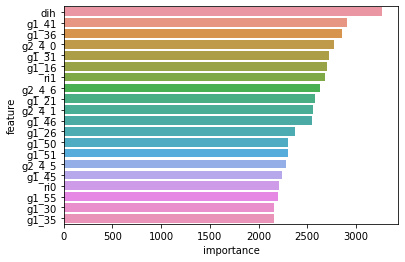

In [6]:
%%time
# Use lightGBM to train
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error
import seaborn as sns

X_data = df_3JHN.drop(['scalar_coupling_constant', 'atom_index_0', 'atom_index_1', 'molecule_name'], axis=1)
y_data = df_3JHN['scalar_coupling_constant']

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=128)
X_train.shape, X_val.shape, y_train.shape, y_val.shape
# ---------------------------------------------------------------
show_ram_usage()

from lightgbm import LGBMRegressor
LGB_PARAMS = {
    'objective': 'regression',
    'metric': 'mae',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.2,
    'num_leaves': 128,
    'min_child_samples': 79,
    'max_depth': 9,
    'subsample_freq': 1,
    'subsample': 0.9,
    'bagging_seed': 11,
    'reg_alpha': 0.1,
    'reg_lambda': 0.3,
    'colsample_bytree': 1.0
}


model = LGBMRegressor(**LGB_PARAMS, n_estimators=1500, n_jobs = -1)
model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
        verbose=100, early_stopping_rounds=200)
print('')
print('Model fit!')
print('')
# ---------------------------------------------------------------
show_ram_usage()

y_pred = model.predict(X_val)
print(' Mean Absolute Error (MAE) : ',mean_absolute_error(y_val, y_pred))
print(' Log of MAE : ',np.log(mean_absolute_error(y_val, y_pred)))
cols = list(X_data.columns)
feat_imp = model.feature_importances_
print(feat_imp[0:5])
df_importance = pd.DataFrame({'feature': cols, 'importance': feat_imp})
df_importance = df_importance.sort_values('importance', ascending=False)[:20]
sns.barplot(x="importance", y="feature", data=df_importance)

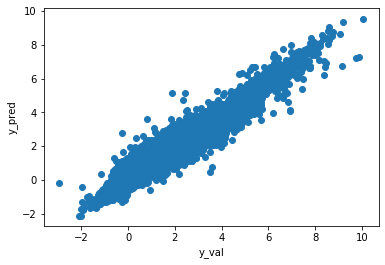

In [7]:
import matplotlib.pyplot as plt

# Create data
x, y = y_val, y_pred
# Plot
plt.scatter(x, y)
plt.title('')
plt.xlabel('y_val')
plt.ylabel('y_pred')
plt.show()